# Visualize TSE, R and S for brain data
While using the R and S values to define the synergy and redundancy dominance

In [10]:
import infotopo_no_prints
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import Bunch

In [2]:
# Define functions

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)
        #Ninfomut = coarse_grain_with_xgi(Ninfomut, 4)
        S_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value < 0)
        R_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value > 0)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

In [37]:
# Import data
# Random timeseries
df_random = pd.read_csv("Data\\timeseries_test.txt", delim_whitespace=True)

# Brain data
df_brain = pd.read_csv("C:\\Users\\cyril\\Documents\\Personal\\Github\\PhD_1\\Data\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt", sep='\t', header=None, usecols=lambda col: col != 'Time')
df_brain = df_brain.transpose()

C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\1812602464.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_random = pd.read_csv("Data\\timeseries_test.txt", delim_whitespace=True)


In [39]:
df_brain.shape[0]

2400

In [52]:
# Set information extraction conditions
df = df_brain
window_size = 1000 #int(df.shape[0]/10)
window_step = 100 #int(df.shape[0]/100)
dimension_max = 4
dimension_tot = 8

TSE_R_S_df = interactions_values(df, window_size, window_step, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_18216\3022628060.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


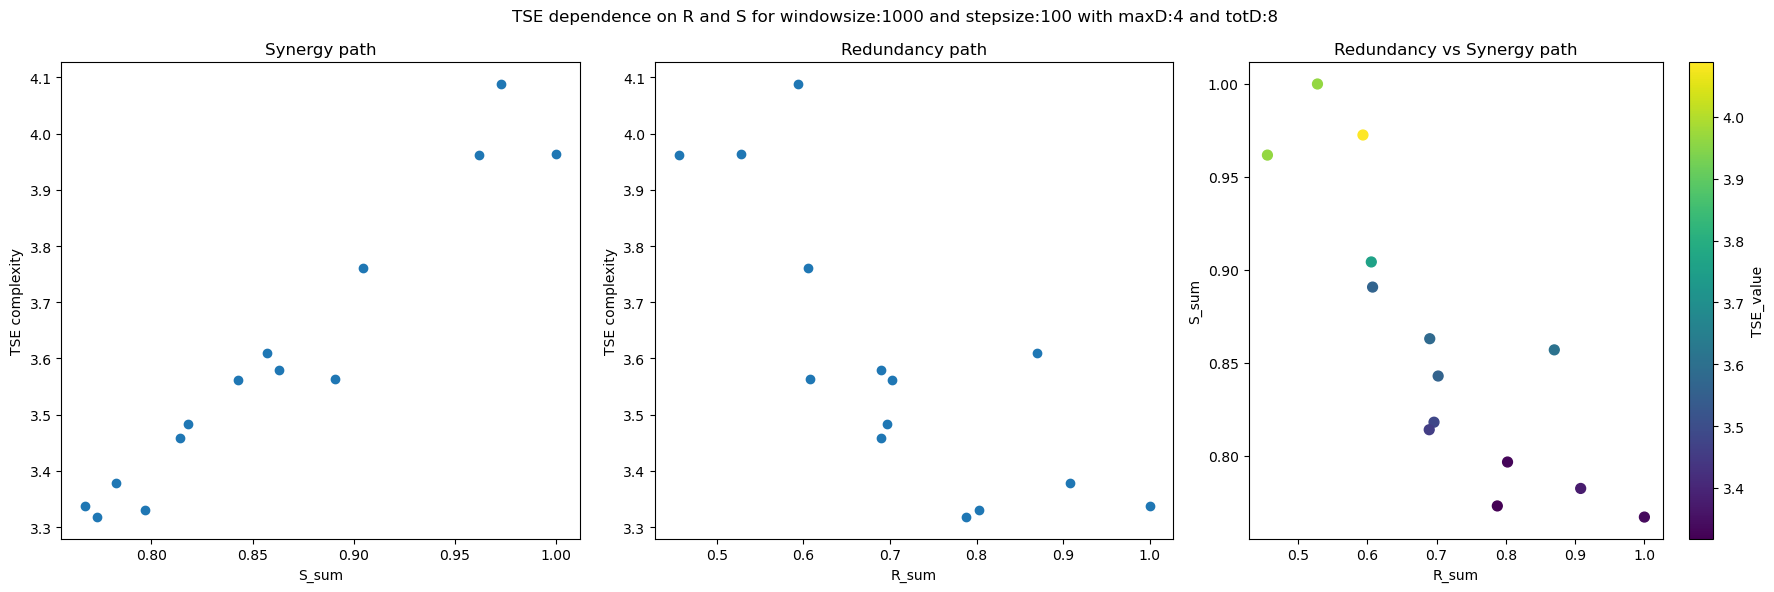

In [53]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.scatter(TSE_R_S_df['S_sum'], TSE_R_S_df['TSE_value'])
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(TSE_R_S_df['R_sum'], TSE_R_S_df['TSE_value'])
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(TSE_R_S_df['R_sum'], TSE_R_S_df['S_sum'], c=TSE_R_S_df['TSE_value'], cmap='viridis', s=50)
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'TSE dependence on R and S for windowsize:{window_size} and stepsize:{window_step} with maxD:{dimension_max} and totD:{dimension_tot}')
plt.tight_layout()
plt.show()